In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
import sklearn

# Описание работы
Музыка - одна из важнейших частей нашей жизни. Она помогает справляться с трудностями, поймать вдохновение, обрести покой. В каждом жанре музыки человек может что-то для себя найти, а самих жанров музыки насчитывается большое количество. Данная работа решает задачу классификации стиля музыки на основе набора данных, полученного с одного из хакатонов Machinehack и содержащего в себе информацию о 19 996 треков.

## 1. Загрузка и чтение данных

In [2]:
path_train = "train.csv"
data_raw = pd.read_csv(path_train)
data_raw.shape

(17996, 17)

In [3]:
path_test = "test.csv"
test_raw = pd.read_csv(path_test)
test_raw.shape

(7713, 16)

In [4]:
data_raw['Artist Name'] = data_raw['Artist Name'].astype('category')
data_raw['Track Name'] = data_raw['Track Name'].astype('category')
data_raw.rename(columns={'Artist Name': 'artist_name'}, inplace=True)
data_raw.rename(columns={'Track Name': 'track_name'}, inplace=True)
data_raw.rename(columns={'Popularity': 'popularity'}, inplace=True)
data_raw.rename(columns={'Class': 'class'}, inplace=True)

## 2. Подготовка данных


Будем руководствоваться анализом из первой лабораторной работы. 
Обработаем пропущенные значения сразу для тренировочной и тестовой выборок

In [5]:
null_feats = pd.DataFrame(data_raw.isnull().sum(), columns = ['nans']).sort_values('nans', ascending = False)
null_feats['nans %'] = np.round(data_raw.isnull().sum() / data_raw.shape[0], 2)
null_feats.head()
nulls = null_feats.index[:3]
data_raw[nulls] = data_raw[nulls].fillna(data_raw[nulls].mean())
data_raw.isnull().sum()

artist_name           0
track_name            0
popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
class                 0
dtype: int64

Удалим такие признаки, как Имя исполнителя и Имя песни

In [6]:
data_raw = data_raw.drop(['artist_name','track_name'], axis=1)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   popularity          17996 non-null  float64
 1   danceability        17996 non-null  float64
 2   energy              17996 non-null  float64
 3   key                 17996 non-null  float64
 4   loudness            17996 non-null  float64
 5   mode                17996 non-null  int64  
 6   speechiness         17996 non-null  float64
 7   acousticness        17996 non-null  float64
 8   instrumentalness    17996 non-null  float64
 9   liveness            17996 non-null  float64
 10  valence             17996 non-null  float64
 11  tempo               17996 non-null  float64
 12  duration_in min/ms  17996 non-null  float64
 13  time_signature      17996 non-null  int64  
 14  class               17996 non-null  int64  
dtypes: float64(12), int64(3)
memory usage: 2.1 MB


Проведем нормализацию количественных признаков

In [7]:
y = data_raw['class']
X = data_raw.drop(['class'],axis=1)

In [8]:
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X.describe()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature
count,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000
mean,0.439516,0.520587,0.662770,0.495245,0.775688,0.636753,0.061348,0.248074,0.178274,0.186489,0.483526,0.492705,0.135896,0.731010
std,0.173924,0.178899,0.235378,0.301265,0.098026,0.480949,0.089626,0.311880,0.265561,0.161129,0.248213,0.158256,0.075812,0.090404
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.323232,0.400689,0.508990,0.300000,0.736292,0.000000,0.013190,0.004317,0.000294,0.086631,0.288002,0.369604,0.112604,0.750000
50%,0.434343,0.522272,0.699994,0.495245,0.797347,1.000000,0.026702,0.081727,0.050049,0.118510,0.478144,0.479016,0.141593,0.750000
75%,0.555556,0.644932,0.859997,0.700000,0.841576,1.000000,0.064879,0.435743,0.178274,0.249064,0.675519,0.596237,0.170926,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Выбор тестовой и обучающей выборки

In [9]:
features = X.columns
features

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_in min/ms', 'time_signature'],
      dtype='object')

In [10]:
X = X.to_numpy()
X.shape

(17996, 14)

In [11]:
y = y.to_numpy(dtype='int32')
y.shape

(17996,)

Разобьем данные на обучающую (75%) и тестовую (25%) выборки:

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(13497, 4499)

In [13]:
y_train.shape, y_test.shape

((13497,), (4499,))

## 4. Подбор гиперпараметров

В качестве *solver* выберем наиболее популярный и эффективный алгоритм Адам

В качестве функции активации выберем Relu

В качетве метрики оценки классификатора возьмем balanced_accuracy_score, поскольку у нас несколько классов, которые несбалансированы.

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score
from tqdm import tqdm

### 4.1 Подбор количества нейронов в однослойной сети

In [15]:
hidden_layer_size = np.linspace(1, 50, 50)
hidden_layer_size = hidden_layer_size.astype(int)
test_err, train_err = [], []
train_acc, test_acc = [], []

for size in tqdm(hidden_layer_size):
    model = MLPClassifier(hidden_layer_sizes=(size,), 
                          solver='adam', activation='relu', max_iter=1000, random_state=13)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(balanced_accuracy_score(y_train, y_train_pred))
    test_acc.append(balanced_accuracy_score(y_test, y_test_pred))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50/50 [14:58<00:00, 17.98s/it]


Train: Min error=0.462250870563829, number of neurons=50
Test: Min error=0.46588130695710156, number of neurons=46


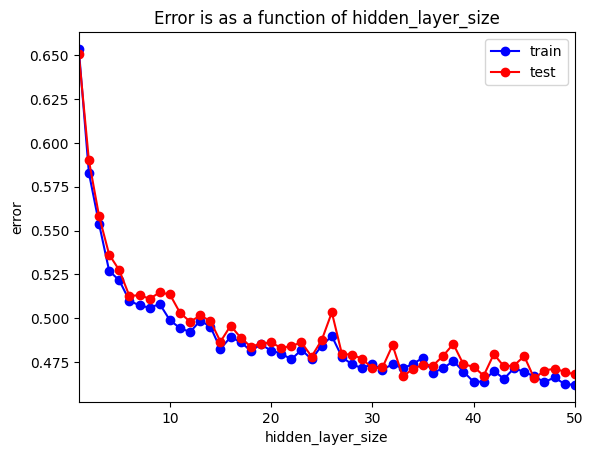

In [16]:
plt.plot(hidden_layer_size, train_err, 'b-o', label = 'train')
plt.plot(hidden_layer_size, test_err, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Error is as a function of hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('error')
plt.legend()

print("Train: Min error={0}, number of neurons={1}".format(np.min(train_err), hidden_layer_size[np.argmin(train_err)]))
print("Test: Min error={0}, number of neurons={1}".format(np.min(test_err), hidden_layer_size[np.argmin(test_err)]))

Train: max accuracy=0.575216948350798, number of neurons=50
Test: max accuracy=0.5732982411628241, number of neurons=46


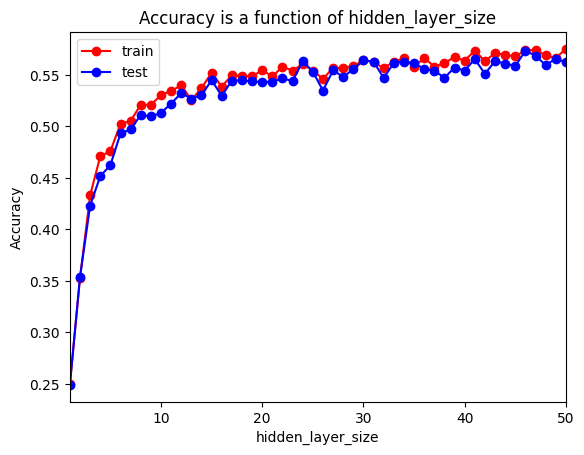

In [17]:
plt.plot(hidden_layer_size, train_acc, 'r-o', label = 'train')
plt.plot(hidden_layer_size, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(hidden_layer_size), np.max(hidden_layer_size)])
plt.title('Accuracy is a function of hidden_layer_size')
plt.xlabel('hidden_layer_size')
plt.ylabel('Accuracy')
plt.legend()

print("Train: max accuracy={0}, number of neurons={1}".format(np.max(train_acc), hidden_layer_size[np.argmax(train_acc)]))
print("Test: max accuracy={0}, number of neurons={1}".format(np.max(test_acc), hidden_layer_size[np.argmax(test_acc)]))

### 4.2 Подбор количества нейронов в двуслойной сети

In [18]:
n = 10
sizes = np.linspace(1, 50, n).astype(int)
test_err = np.zeros((n, n))
train_err = np.zeros((n, n))
train_acc = np.zeros((n, n))
test_acc = np.zeros((n, n))

for i, size_1 in tqdm(enumerate(sizes)):
    for j, size_2 in enumerate(sizes):
        model = MLPClassifier(hidden_layer_sizes=(size_1, size_2, ), 
                              solver='adam', activation='relu', max_iter=1000, random_state=13)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_err[i][j] = np.mean(y_train != y_train_pred)
        test_err[i][j] = np.mean(y_test != y_test_pred)

        train_acc[i][j] = balanced_accuracy_score(y_train, y_train_pred)
        test_acc[i][j] = balanced_accuracy_score(y_test, y_test_pred)

10it [39:34, 237.42s/it]


Train: Min error=0.43305919834037193, number of neurons=45,45
Test: error=0.4756612580573461, number of neurons=45,45

Test: Min error=0.4585463436319182, number of neurons=40,45
Train: error=0.44935911684077945, number of neurons=40,45



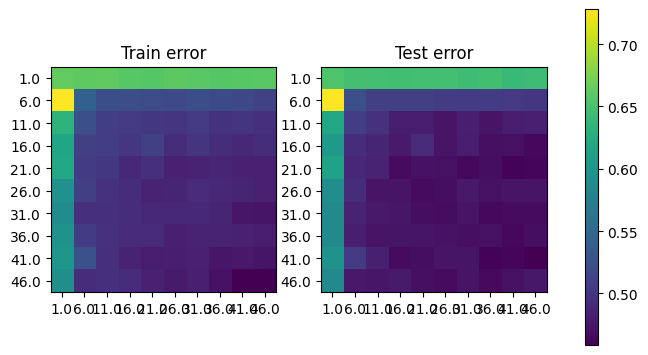

In [19]:
plt.subplot(121)
plt.title("Train error")
plt.imshow(train_err)
plt.xticks(np.arange(n), np.arange(1, 50, 50 / n))
plt.yticks(np.arange(n), np.arange(1, 50, 50 / n))

plt.subplot(122)
plt.title("Test error")
plt.imshow(test_err)
plt.xticks(np.arange(n), np.arange(1, 50, 50 / n))
plt.yticks(np.arange(n), np.arange(1, 50, 50 / n))

cax = plt.axes([0.96, 0.15, 0.02, 0.7])
plt.colorbar(cax=cax)

train_min_loss = np.where(train_err == np.min(train_err))
test_min_loss = np.where(test_err == np.min(test_err))

train_min_loss_sizes = [train_min_loss[0][0] * 5, train_min_loss[1][0] * 5]
test_min_loss_sizes = [test_min_loss[0][0] * 5, test_min_loss[1][0] * 5]

print("Train: Min error={0}, number of neurons={1},{2}".format(np.min(train_err), train_min_loss_sizes[0], train_min_loss_sizes[1]))
print("Test: error={0}, number of neurons={1},{2}\n".format(test_err[train_min_loss][0], train_min_loss_sizes[0], train_min_loss_sizes[1]))
print("Test: Min error={0}, number of neurons={1},{2}".format(np.min(test_err), test_min_loss_sizes[0], test_min_loss_sizes[1]))
print("Train: error={0}, number of neurons={1},{2}\n".format(train_err[test_min_loss][0], test_min_loss_sizes[0], test_min_loss_sizes[1]))

Train: Max accuracy=0.6133336112411021, number of neurons=45,40
Test: accuracy=0.5774093992907414, number of neurons=45,40

Test: Max accuracy=0.5808947274241927, number of neurons=40,40
Train: accuracy=0.5928317755422886, number of neurons=40,40



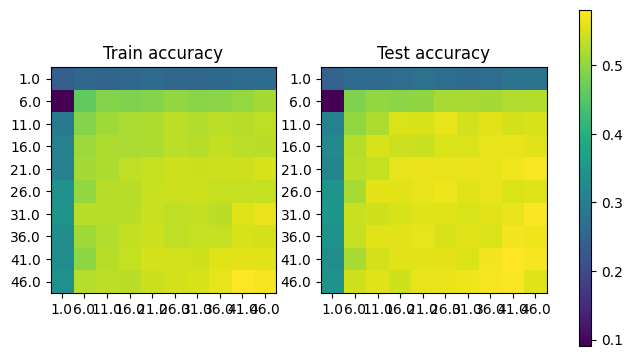

In [20]:
plt.subplot(121)
plt.title("Train accuracy")
plt.imshow(train_acc)
plt.xticks(np.arange(n), np.arange(1, 50, 50 / n))
plt.yticks(np.arange(n), np.arange(1, 50, 50 / n))

plt.subplot(122)
plt.title("Test accuracy")
plt.imshow(test_acc)
plt.xticks(np.arange(n), np.arange(1, 50, 50 / n))
plt.yticks(np.arange(n), np.arange(1, 50, 50 / n))

cax = plt.axes([0.95, 0.15, 0.02, 0.7])
plt.colorbar(cax=cax)

train_max_acc = np.where(train_acc == np.max(train_acc))
test_max_acc = np.where(test_acc == np.max(test_acc))

train_max_acc_sizes = [train_max_acc[0][0] * 5, train_max_acc[1][0] * 5]
test_max_acc_sizes = [test_max_acc[0][0] * 5, test_max_acc[1][0] * 5]

print("Train: Max accuracy={0}, number of neurons={1},{2}".format(np.max(train_acc), train_max_acc_sizes[0], train_max_acc_sizes[1]))
print("Test: accuracy={0}, number of neurons={1},{2}\n".format(test_acc[train_max_acc][0], train_max_acc_sizes[0], train_max_acc_sizes[1]))
print("Test: Max accuracy={0}, number of neurons={1},{2}".format(np.max(test_acc), test_max_acc_sizes[0], test_max_acc_sizes[1]))
print("Train: accuracy={0}, number of neurons={1},{2}\n".format(train_acc[test_max_acc][0], test_max_acc_sizes[0], test_max_acc_sizes[1]))

Построим для лучшего варианта (сеть из 2х слоев: 40,40) матрицу рассогласования.

In [21]:
model = MLPClassifier(hidden_layer_sizes=(40, 40, ), 
                      solver='adam', activation='relu', max_iter=1000, random_state=13)
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)

c:\users\alexandra sidorova\documents\machine_learning_course\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


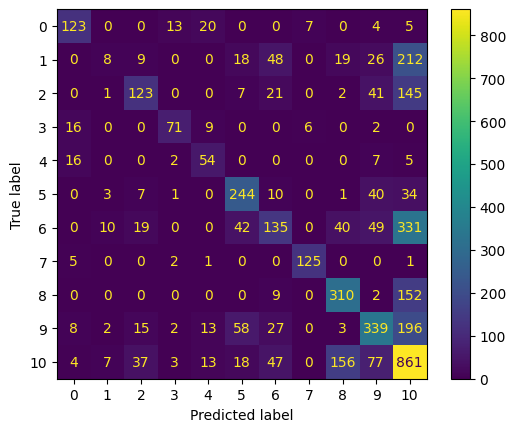

In [22]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test) 

### 4.3 Подбор параметра регуляризации

Лучшие показатели подемонстрировала сеть из 2х слоев, причем при количесте нейронов (40,40), следовательно, подбирать параметра _alpha_ будем для нее. Уточним, что переобучение или недообучение не прослеживаются, но тем не менее для чистоты эксперимента попробуем рассмотреть подбор параметра

In [23]:
alphas = np.logspace(-5, 5, 50)
test_err, train_err = [], []
train_acc, test_acc = [], []


for alpha in tqdm(alphas):
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (40,40,), 
                              solver='adam', activation='relu', max_iter=1000, random_state=13)
    
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    
    train_acc.append(balanced_accuracy_score(y_train, y_train_pred))
    test_acc.append(balanced_accuracy_score(y_test, y_test_pred))

100%|██████████████████████████████████████████████████████████████████████████████████████| 50/50 [8:30:11<00:00, 612.24s/it]


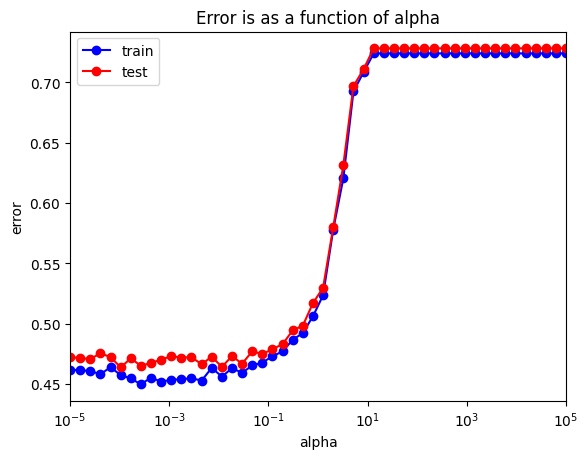

In [24]:
plt.semilogx(alphas, train_err, 'b-o', label = 'train')
plt.semilogx(alphas, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alphas), np.max(alphas)])
plt.title('Error is as a function of alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

In [31]:
print("Train: Min error={0}, alpha={1}".format(np.min(train_err), alphas[np.argmin(train_err)]))
print("Test: error={0}, alpha={1}\n".format(test_err[np.argmin(train_err)], alphas[np.argmin(train_err)]))
print("Test: Min error={0}, alpha={1}".format(np.min(test_err), alphas[np.argmin(test_err)]))
print("Train: error={0}, alpha={1}\n".format(train_err[np.argmin(test_err)], alphas[np.argmin(test_err)]))

Train: Min error=0.4496554789953323, alpha=0.0002682695795279727
Test: error=0.46499222049344296, alpha=0.0002682695795279727

Test: Min error=0.46365859079795513, alpha=0.00010481131341546853
Train: error=0.45728680447506853, alpha=0.00010481131341546853



In [32]:
print("Train: max accuracy={0}, number of neurons={1}".format(np.max(train_acc), alphas[np.argmax(train_acc)]))
print("Test: accuracy={0}, number of neurons={1}\n".format(test_acc[np.argmax(train_acc)], alphas[np.argmax(train_acc)]))
print("Test: max accuracy={0}, number of neurons={1}".format(np.max(test_acc), alphas[np.argmax(test_acc)]))
print("Train: accuracy={0}, number of neurons={1}\n".format(train_acc[np.argmax(test_acc)], alphas[np.argmax(test_acc)]))

Train: max accuracy=0.5859628334708298, number of neurons=0.0002682695795279727
Test: accuracy=0.5652327819429102, number of neurons=0.0002682695795279727

Test: max accuracy=0.5696131892822834, number of neurons=1e-05
Train: accuracy=0.5835703811751353, number of neurons=1e-05



## 5. Выводы

### 5.1 Подбор числа нейронов в однослойном моделе
- Практически полное совпадение графиков Error/Accuracy для train/test говорит об почти одинаковом распределении тренировочных и тестовых данных.
- Переобучения и недобучения нет, что свидетельствует о том, что в модели нет высоких весовых значений и модель достаточно простая, чтобы уметь обощаться, но в то же время и достаточно сложная, чтобы решать поставленную задачу.
- За оптимальный размер скрытого слоя возьмем минимум ошибки и максимум accuracy на тестовой выборке 57.32% - 46 нейрона.
- При количестве нейронов в слое больше 5 ошибка перестает сильно уменьшаться.

### 5.2 Подбор числа нейронов в двуслойной моделе
- Переобучения и недобучения также необнаружено
- За оптимальные размеры скрытых слоев возьмем минимум ошибки и максимум accuracy на тестовой выборке 58.08% - 40 и 40 нейронов.
- Заметим, что количество нейронов увеличилось больше, чем в 10 раз, а точность при этом увеличилась почти на 0.7%.

### 5.3 Подбор параметра регуляризации
- Заметим, что с ростом коэффициента регуляризации растет ошибка и падает accuracy, что говорит о том, что после обучения у модели не возникает больших значения весовых коэффициентов, а значит нет переобучения у модели.
- При _lambda_ > 10e-1 начинается рост ошибки и снижение accuracy. То есть с ростом _alpha_ уменьшаются веса модели и стремятся к нулю
- Также не удалось подобрать другую такую _alpha_, чтобы точность модели стала выше 58.08%, которая была получена при _alpha_ равной _1e-4_